# Multiclass clssification using sklearn

Overview. This notebook aims to ...
1. Classify pain, vicarious, cognitive maps based on single trials 
2. Classify pain, vicarious, cogntiive maps based on contrast maps

In [5]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

def balance_data_by_group(X, Y, groups):
    """
    Balances data within each group for each class to the smallest class size within each group.
    
    Parameters:
    - X (np.ndarray): Feature data array.
    - Y (np.ndarray): Factorized labels array.
    - groups (np.ndarray or list): Array of group labels.
    
    Returns:
    - X_balanced (np.ndarray): Balanced feature data array.
    - Y_balanced (np.ndarray): Balanced labels array.
    - groups_balanced (np.ndarray): Balanced group labels array.
    """
    # Convert groups to an array if it's not already
    groups_array = np.array(groups)

    # Find unique groups
    unique_groups = np.unique(groups_array)

    # Initialize lists to hold the balanced dataset
    X_balanced = []
    Y_balanced = []
    groups_balanced = []

    for group in unique_groups:
        # Indices for the current group
        group_indices = np.where(groups_array == group)[0]

        # Extract current group's data and labels
        X_group = X[group_indices]
        Y_group = Y[group_indices]
        
        # Get the smallest class size within this group
        min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
        if min_class_size > 0:
            # Initialize temporary lists for the group's balanced data
            X_group_balanced = []
            Y_group_balanced = []
            
            # Balance each class within the group
            for class_label in np.unique(Y_group):
                # Indices for the current class within the group
                class_indices = np.where(Y_group == class_label)[0]
                
                # Resample the class to the target size
                resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
                
                # Append resampled data and labels to the group's temporary lists
                X_group_balanced.append(X_group[resampled_indices])
                Y_group_balanced.append(Y_group[resampled_indices])
            
            # Concatenate balanced data for the current group and append to the overall balanced lists
            X_balanced.append(np.vstack(X_group_balanced))
            Y_balanced.append(np.concatenate(Y_group_balanced))
            groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
        else:
            print(f"{group} does not have trials in one of the classes")

    # Concatenate all balanced data from each group to form the final balanced dataset
    X_balanced = np.vstack(X_balanced)
    Y_balanced = np.concatenate(Y_balanced)
    groups_balanced = np.array(groups_balanced)

    return X_balanced, Y_balanced, groups_balanced


In [6]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[1]

# 1. apply prob atlas to single trial

In [30]:
atlas_filename = '/Users/h/Documents/MATLAB/Neuroimaging_Pattern_Masks/Atlases_and_parcellations/2023_CANLab_atlas/src/CANLab2023_MNI152NLin2009cAsym_scaffold.nii.gz'
atlas_img = image.load_img(atlas_filename)
# Load the standard MNI template at 2mm resolution provided by nilearn
target_img = datasets.load_mni152_template(resolution=2)

# Load the CSV file containing labels
labels_csv = '/Users/h/Documents/MATLAB/Neuroimaging_Pattern_Masks/Atlases_and_parcellations/2023_CANLab_atlas/src/CANLab2023_MNI152NLin2009cAsym_labels.csv'
labels_df = pd.read_csv(labels_csv)

In [7]:
atlas_img.get_fdata().shape

(193, 229, 193, 542)

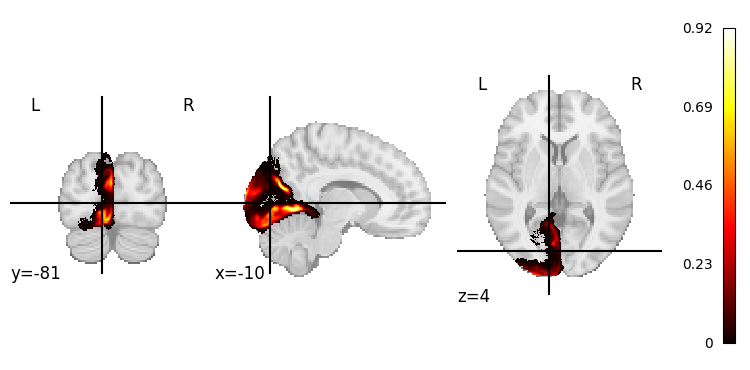

In [10]:
atlas3 = image.index_img(atlas_img, 3)
plotting.plot_stat_map(atlas3)

# Juelich atlas

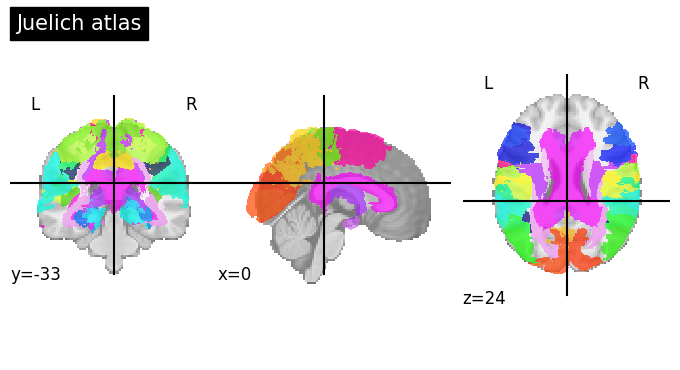

In [11]:
from nilearn import datasets
dataset_ju = datasets.fetch_atlas_juelich("maxprob-thr0-1mm")
atlas_ju_filename = dataset_ju.filename
plotting.plot_roi(atlas_ju_filename, title="Juelich atlas")

masker = NiftiLabelsMasker(labels_img=atlas_ju_filename, standardize=True)



In [12]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/'
sub = "sub-0101"

flist = glob.glob(join(singletrial_dir, sub, f"{sub}_ses-*_run-*_runtype-pain_event-stimulus_trial-*_cuetype-*_stimintensity-*.nii.gz"))


In [35]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/'
sub = "sub-0101"

flist = glob.glob(join(singletrial_dir, sub, f"{sub}_ses-*_run-*_runtype-pain_event-stimulus_trial-*_cuetype-*_stimintensity-*.nii.gz"))
# load all the images -> average -> transform to fslr
# all_imgs = image.concat_imgs(flist)
# mean_img = image.mean_img(all_imgs)
# sub101 = neuromaps.transforms.mni152_to_fslr(mean_img, fslr_density='32k', method='linear')
# mean_img is now a NIfTI-like image containing the average of all input images
# parcellate per single trial
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parcelarray = []
for fname in flist:
    singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
    parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
    singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
    parcelarray.append(singletrial_parc)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/2944819099.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


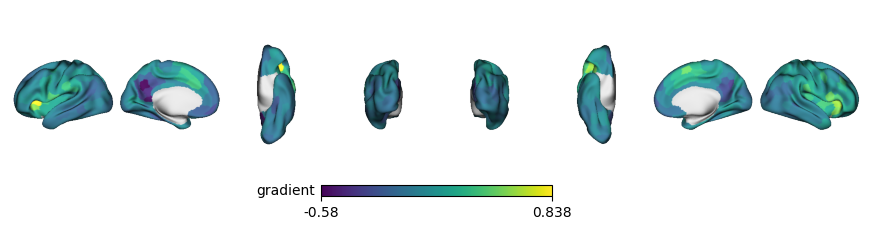

In [36]:
average_parcel = np.vstack(parcelarray).mean(axis=0)


# fcgradient = fetch_annotation(source='margulies2016', desc='fcgradient02', space='fsLR', den='32k')
schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
# sub101_parc = parc.fit_transform(sub101, 'fsLR')
sub101_img = parc.inverse_transform(average_parcel)

surfaces_fslr = fetch_fslr()
lh_fslr, rh_fslr = surfaces_fslr['inflated']

# color_range = (0,.15)
p = Plot(surf_lh=lh_fslr,
            surf_rh=rh_fslr, 
            size=(1000, 200), 
            zoom=1.2, layout='row', 
            views=['lateral', 'medial', 'ventral', 'posterior'], 
            mirror_views=True, brightness=.7)
p.add_layer({'left': sub101_img[0], 
            'right': sub101_img[1]}, 
            cmap='viridis', cbar=True,
            # color_range=color_range,
            cbar_label='gradient'
            ) # YlOrRd_r
cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
fig = p.build(cbar_kws=cbar_kws)
fig.show()

# 1. pipeline for multiclass
* load single trials
* Parcellate 
* save data into array with metadaa
* apply crossvalidation on data

In [42]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/'
# sub = "sub-0101"
subdirectories = glob.glob(join(singletrial_dir, "sub-*"))
flists = []
for subdir in subdirectories:
    sub = os.path.basename(subdir)
    flist = glob.glob(join(singletrial_dir, sub, f"{sub}_ses-*_run-*_runtype-*_event-stimulus_trial-*_cuetype-*_stimintensity-*.nii.gz"))
    flists.append(flist)




In [44]:
len(flists)

112

In [48]:
flattened_list = [item for sublist in flists for item in sublist]


In [50]:
flattened_list[0]

'/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0117/sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-med.nii.gz'

# 2. run only once - extract parcel value from roi

In [51]:
# schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
# parcelarray = []
# metadata = []
# for fname in flattened_list:
#     metadata.append(os.path.basename(fname))
#     singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
#     parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#     singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
#     parcelarray.append(singletrial_parc)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

In [77]:
# np.save('/Volumes/seagate/cue_singletrials/singletrial-pvc_atlas-schaefer2018.npy',parcel_value)

# data = {
#     "code_generated": "scripts/step12_multiclass/multiclass_parcels.ipynb",
#     "code_parcellate": """schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
#                         parcelarray = []
#                         metadata = []
#                         for fname in flattened_list:
#                             metadata.append(os.path.basename(fname))
#                             singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
#                             parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#                             singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
#                             parcelarray.append(singletrial_parc)""",
#     "atlas": "Schaefer2018_400Parcels_7Networks_order",
#     "python_packages": ["neuromaps", "netneurotools"]
# }
# with open('/Volumes/seagate/cue_singletrials/singletrial-pvc_atlas-schaefer2018.json', 'w') as json_file:
#     json.dump(data, json_file, indent=4)

In [165]:
metadata

['sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-010_cuetype-high_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-001_cuetype-high_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-06_runtype-vicarious_event-stimulus_trial-004_cuetype-low_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-01_runtype-vicarious_event-stimulus_trial-004_cuetype-high_stimintensity-high.nii.gz',
 'sub-0117_ses-01_run-01_runtype-vicarious_event-stimulus_trial-000_cuetype-low_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-06_runtype-vicarious_event-stimulus_trial-002_cuetype-high_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-003_cuetype-high_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-004_cuetype-low_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-03_runtyp

In [73]:
metadatadf = pd.DataFrame(metadata, columns=['filename'])

df_split = metadatadf['filename'].str.extract(
    r'(?P<sub>sub-\d+)_ses-(?P<ses>\d+)_run-(?P<run>\d+)_runtype-(?P<runtype>\w+)_event-(?P<event>\w+)_trial-(?P<trial>\d+)_cuetype-(?P<cuetype>\w+)_stimintensity-(?P<stimintensity>\w+)'
)

df_final = pd.concat([metadatadf, df_split], axis=1)
df_final.head()
df_final.to_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t', index=False, header=True)


filename       sub ses run  \
0  sub-0117_ses-01_run-02_runtype-cognitive_event...  sub-0117  01  02   
1  sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117  01  05   
2  sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117  01  05   
3  sub-0117_ses-01_run-06_runtype-vicarious_event...  sub-0117  01  06   
4  sub-0117_ses-01_run-01_runtype-vicarious_event...  sub-0117  01  01   

     runtype     event trial cuetype stimintensity  
0  cognitive  stimulus   006     low           med  
1  cognitive  stimulus   010    high           med  
2  cognitive  stimulus   001    high           low  
3  vicarious  stimulus   004     low           low  
4  vicarious  stimulus   004    high          high

In [54]:
parcel_value = np.vstack(parcelarray)

# 3. load data (MUST)

In [7]:
parcel_value = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.npy'))
print(f"the shape of the parcel data {parcel_value.shape}")
df_final = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t')

schaefer = nnt_data.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


the shape of the parcel data (20029, 400)


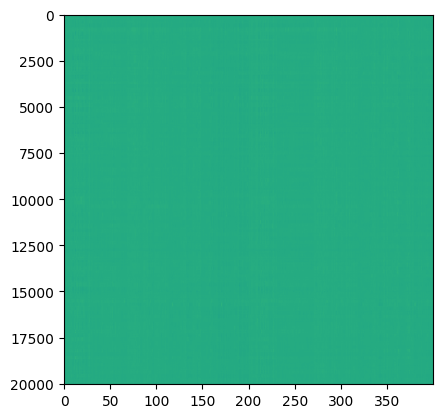

In [8]:
plt.imshow(parcel_value, aspect=.02, cmap='viridis')

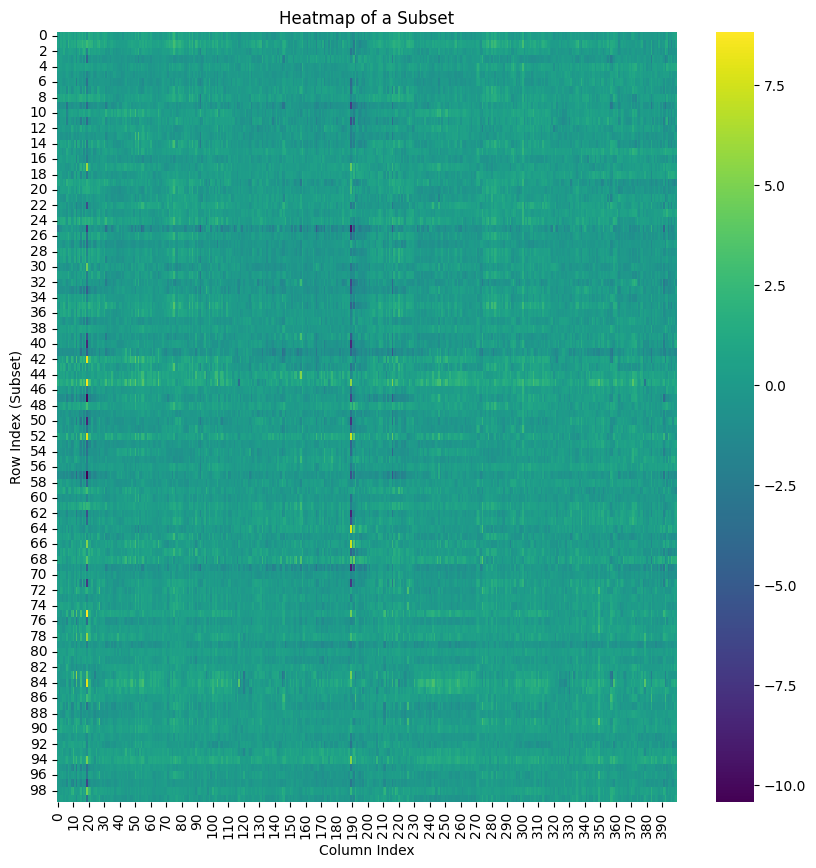

In [9]:
import seaborn as sns

# Selecting a subset (e.g., first 100 rows)
subset = parcel_value[:100, :]

plt.figure(figsize=(10, 10))
sns.heatmap(subset, cmap='viridis', cbar=True)
plt.title('Heatmap of a Subset')
plt.xlabel('Column Index')
plt.ylabel('Row Index (Subset)')
plt.show()


In [11]:
df_final

filename       sub  ses  run  \
0      sub-0117_ses-01_run-02_runtype-cognitive_event...  sub-0117    1    2   
1      sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117    1    5   
2      sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117    1    5   
3      sub-0117_ses-01_run-06_runtype-vicarious_event...  sub-0117    1    6   
4      sub-0117_ses-01_run-01_runtype-vicarious_event...  sub-0117    1    1   
...                                                  ...       ...  ...  ...   
20024  sub-0111_ses-04_run-06_runtype-pain_event-stim...  sub-0111    4    6   
20025  sub-0111_ses-03_run-05_runtype-vicarious_event...  sub-0111    3    5   
20026  sub-0111_ses-03_run-03_runtype-cognitive_event...  sub-0111    3    3   
20027  sub-0111_ses-04_run-03_runtype-cognitive_event...  sub-0111    4    3   
20028  sub-0111_ses-04_run-04_runtype-cognitive_event...  sub-0111    4    4   

         runtype     event  trial cuetype stimintensity  groupsinterim  
0      cognitive  stimulus      6     low           med              1  
1      cognitive  stimulus     10    high           med              1  
2      cognitive  stimulus      1    high           low              1  
3      vicarious  stimulus      4     low           low              1  
4      vicarious  stimulus      4    high          high              1  
...          ...       ...    ...     ...           ...            ...  
20024       pain  stimulus      7    high          high            112  
20025  vicarious  stimulus      0    high           med            112  
20026  cognitive  stimulus     10     low           low            112  
20027  cognitive  stimulus      9     low           med            112  
20028  cognitive  stimulus      3    high           low            112  

[20029 rows x 10 columns]

## 3-1. organize X, Y, groups

In [13]:
groups = df_final['groupsinterim']
Yinterim, uniques = pd.factorize(df_final['runtype'])
X = parcel_value
Y = Yinterim

In [14]:
uniques

Index(['cognitive', 'vicarious', 'pain'], dtype='object')

In [15]:
min_class_size = np.bincount(Y).min()

## 3-2. balancer
some participants don't have equal number of trials
we balance it here

In [17]:
X_balanced, Y_balanced, groups_balanced = balance_data_by_group(X, Y, groups)

89 does not have trials in one of the classes


In [19]:
print(X_balanced.shape)
print(Y_balanced.shape)
print(groups_balanced.shape)

(18570, 400)
(18570,)
(18570,)


# 4. SVM

In [20]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold
import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)

i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    Y_train, Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 93.07%
Elapsed time: 283.4813947240182 seconds


In [192]:
accuracies

[0.9460470085470085,
 0.9230769230769231,
 0.9385683760683761,
 0.9074074074074074,
 0.9242919389978214,
 0.9492521367521367,
 0.9185544768069039,
 0.9444444444444444,
 0.900974025974026,
 0.954248366013072]

## 4-1. check SVM 1) cross correlation of all the weights

Grab the weights per fold and calculate cross correlation, alongside average correlation and standard deviation (signficance as well)

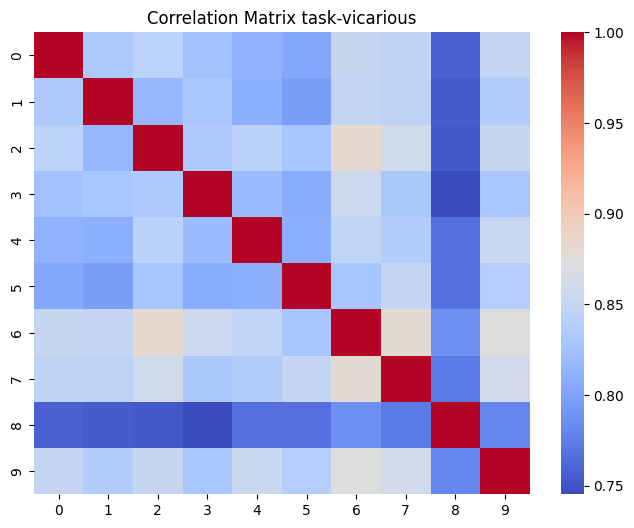

In [60]:
# convert correlation into a weight matrix ____________________________________
weights_class1 = []
for i in range(10):
    weights_class1.append(weights_per_fold[i][1])
weights_class_1 = np.vstack(weights_class1)
weights_class_1.shape
corr_matrix = np.corrcoef(weights_class_1.T, rowvar=False)

# calculate average correlation ____________________________________
upper_tri_indices = np.triu_indices(n=corr_matrix.shape[0], k=1)
# Extract the upper triangular values from the correlation matrix
upper_tri_values = corr_matrix[upper_tri_indices]
# Calculate the mean of these values
mean_pairwise_correlation = np.mean(upper_tri_values)
mean_pairwise_correlation
 
# plot correlation coefficients ____________________________________
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix,cmap='coolwarm', cbar=True, cbar_kws={} )
plt.title(f'Correlation Matrix task-{uniques[1]}')
plt.show()

## 4-2. check SVM 2) distribution of weights
distribution of weights

Text(0, 0.5, 'Density')

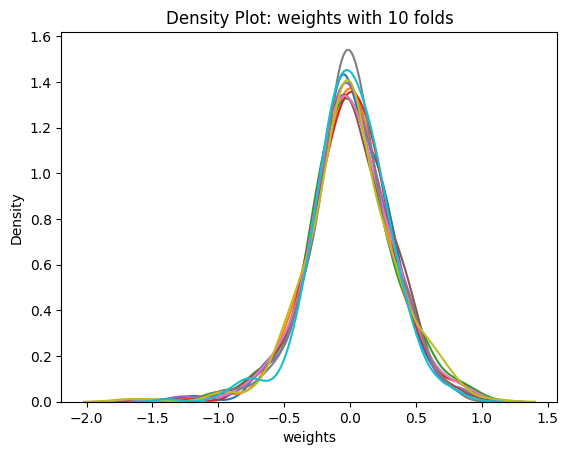

In [61]:

# Iterate through the five airlines
for i, weight in enumerate(weights_class_1):

    # Draw the density plot
    sns.kdeplot(weight, 
                legend=True,
                cbar=True)
    
# Plot formatting
# plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot: weights with 10 folds')
plt.xlabel('weights')
plt.ylabel('Density')

## 4-3. ROC curve

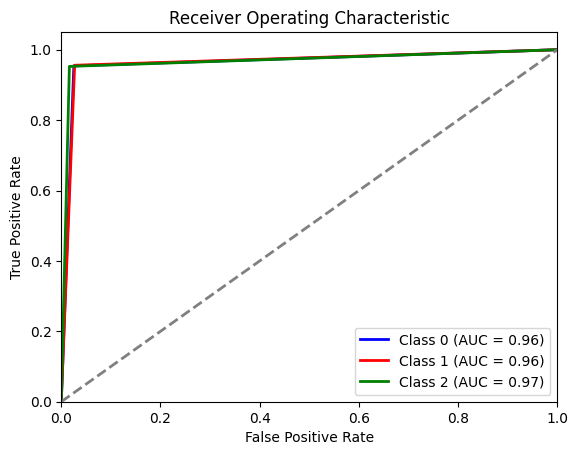

In [193]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


## 4-4. confusion matrix

"""
> There is separation across classes, using the pattern of 400 parcels across pariticpants. Pain, vicarious, cognitive parcel weights are unique enough to lead to high accuracy classification.
"""

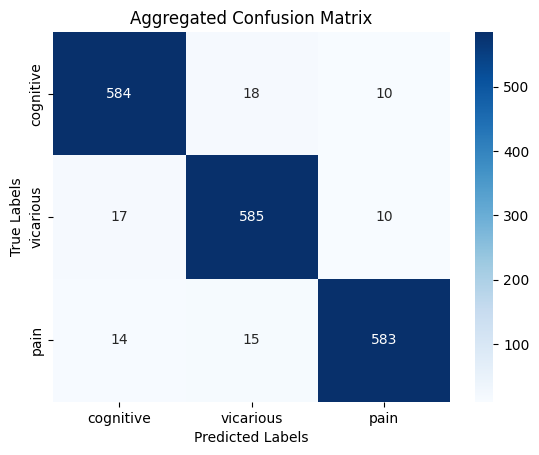

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
original_class_names = np.array(uniques)

# Compute the confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=original_class_names, yticklabels=original_class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Aggregated Confusion Matrix')
plt.show()


# 5. plotting weigthmaps
* I average the weights across the number of folds
* From that, I plot the weights per each parcel

In [92]:
print(uniques)
weights_per_fold

Index(['cognitive', 'vicarious', 'pain'], dtype='object')


[array([[-0.15514418,  0.14470625, -0.38773734, ...,  0.21324504,
          0.02647545,  0.13598171],
        [ 0.13312132, -0.12372802,  0.24912002, ...,  0.25600338,
          0.00046323,  0.31117827],
        [ 0.00949076, -0.01661291,  0.16990779, ..., -0.43180707,
         -0.07209727,  0.42665182]]),
 array([[ 0.04881613, -0.05953031, -0.22944656, ...,  0.02896057,
         -0.02173744,  0.13326068],
        [ 0.05287408, -0.0728798 ,  0.184544  , ...,  0.0788201 ,
          0.1872574 ,  0.26775656],
        [-0.05375827, -0.0059291 ,  0.2419122 , ..., -0.23994764,
          0.25328673,  0.35217174]]),
 array([[ 0.1448078 ,  0.30987924, -0.33366506, ...,  0.15680434,
          0.19818551,  0.05761485],
        [ 0.04506045, -0.3439056 ,  0.08647441, ...,  0.23086752,
         -0.01522014,  0.31727473],
        [-0.06683149, -0.12226467,  0.05554432, ..., -0.42607436,
         -0.02583376,  0.31214934]]),
 array([[-0.29631165,  0.19014572, -0.32575024, ..., -0.04062442,
         -

In [93]:
uniques

Index(['cognitive', 'vicarious', 'pain'], dtype='object')

## 5-1. average weightmaps

In [94]:

# Extracting the first element (weights) from each fold
cog_to_average = [weights_per_fold[i][0] for i in range(10)]
cog_mean = np.mean(np.vstack(cog_to_average), axis=0)

vic_to_average = [weights_per_fold[i][1] for i in range(10)]
vic_mean = np.mean(np.vstack(vic_to_average), axis=0)

pain_to_average = [weights_per_fold[i][2] for i in range(10)]
pain_mean = np.mean(np.vstack(pain_to_average), axis=0)

# inverse transform average weights back into parcel space
cog = parc.inverse_transform(cog_mean)
vic = parc.inverse_transform(vic_mean)
pain = parc.inverse_transform(pain_mean)

In [95]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


## 5-2. create color gradient

In [125]:
# hm_viridis_onesided = LinearSegmentedColormap.from_list('homemade_viridis_one_side', (
#     # Edit this gradient at https://eltos.github.io/gradient/#homemade_viridis_one_side=E62D4F-3648A6-42A7CB-4D9421-E0DB1E
#     (0.000, (0.902, 0.176, 0.310)),
#     (0.250, (0.212, 0.282, 0.651)),
#     (0.500, (0.259, 0.655, 0.796)),
#     (0.750, (0.302, 0.580, 0.129)),
#     (1.000, (0.878, 0.859, 0.118))))

(<nibabel.gifti.gifti.GiftiImage at 0x1657c3e50>,
 <nibabel.gifti.gifti.GiftiImage at 0x16574c790>)

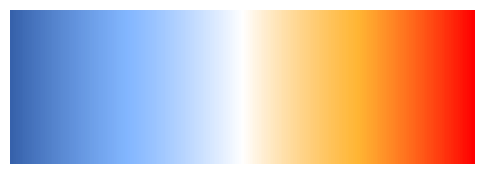

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()


## 5-3. average SVM weights per each class
> Most of the significant weights are high within the primary sensory cortices.
The parcels are also interdigitated in terms of the tasks that are most predictive of the categories. 
For instance, the early visual cortex has the highest weight in the cognitive maps, but the adjacent higher order visual cortex has tive weights, more higher weights for pain tasks. 
Given the classifier was a one vs rest classifier, we're maximizing the distance and thereby parcels that would commonly predictive of both tasks would probably be pooled out of the highest weights. 

In [126]:
print(f"cognitive range: {np.min(cog_mean)}, {np.max(cog_mean)}")
print(f"vicarious range: {np.min(vic_mean)}, {np.max(vic_mean)}")
print(f"pain range: {np.min(pain_mean)}, {np.max(pain_mean)}")


cognitive range: -1.976485853313583, 1.235818416135149
vicarious range: -1.4027751732566383, 0.8692230118604278
pain range: -1.485691455126672, 1.132679164501718


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


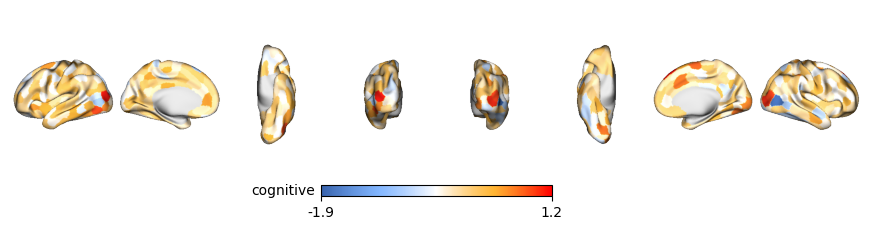

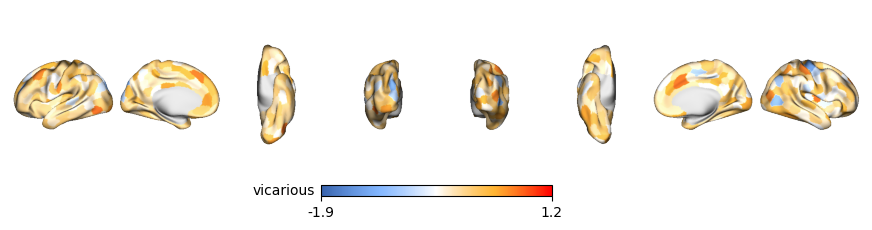

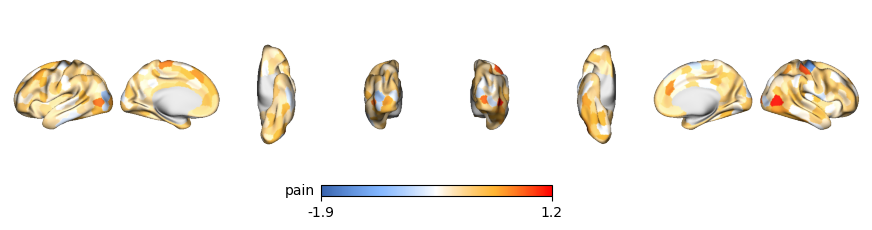

In [134]:
plot_brain_surfaces(image=cog, cbar_label='cognitive', cmap=cmap, color_range=(-1.9, 1.2))
plot_brain_surfaces(image=vic, cbar_label='vicarious', cmap=cmap, color_range=(-1.9,1.2))
plot_brain_surfaces(image=pain, cbar_label='pain', cmap=cmap, color_range=(-1.9,1.2))

# permutation

In [160]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import numpy as np

n_permutations = 1000
accuracies_permuted = []

for i in range(n_permutations):
    # Shuffle the labels
    Y_permuted = shuffle(Y_balanced)
    
    # Perform cross-validation with the permuted labels
    cv = StratifiedKFold(n_splits=10)
    acc_scores_permute = []
    
    for train_idx, test_idx in cv.split(X_balanced, Y_permuted):
        X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
        Y_train, Y_test = Y_permuted[train_idx], Y_permuted[test_idx]
        
        svm_permute = SVC(kernel='linear', decision_function_shape='ovr').fit(X_train, Y_train)
        Y_pred_permute = svm_permute.predict(X_test)
        
        acc_scores_permute.append(accuracy_score(Y_test, Y_pred_permute))
    
    # Store the mean accuracy for this permutation
    accuracies_permuted.append(np.mean(acc_scores_permute))

# Calculate the empirical p-value
original_accuracy = 93.07# (Your model's original accuracy)
p_value = np.sum(accuracies_permuted >= original_accuracy) / n_permutations

print(f"Empirical p-value: {p_value}")


KeyboardInterrupt: 

# PCA

In [148]:
X_balanced.shape

(18570, 400)

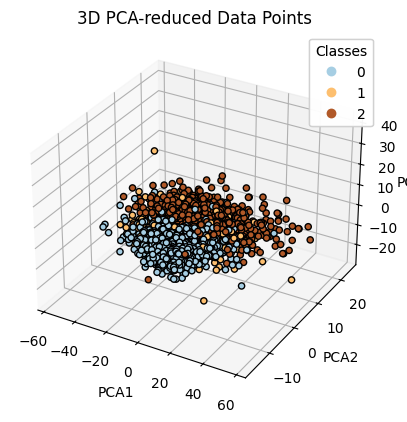

In [150]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Fit the SVM on the reduced data
svm = SVC(kernel='linear', decision_function_shape='ovr').fit(X_reduced, Y_balanced)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot also the training points
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_balanced, edgecolors='k', cmap=plt.cm.Paired, depthshade=False)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


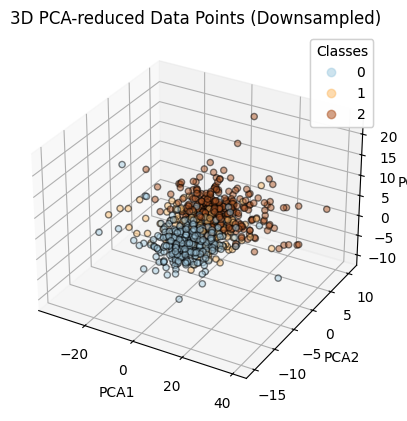

In [153]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Randomly sample a subset of the data points for a clearer plot
subset_indices = np.random.choice(X_reduced.shape[0], size=1000, replace=False)  # Adjust the size as needed
X_subset = X_reduced[subset_indices]
Y_subset = Y_balanced[subset_indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the training points with transparency
scatter = ax.scatter(X_subset[:, 0], X_subset[:, 1], X_subset[:, 2], c=Y_subset, edgecolors='k', alpha=0.5, cmap=plt.cm.Paired)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points (Downsampled)')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [ ]:
X_balanced

## cumulative variance

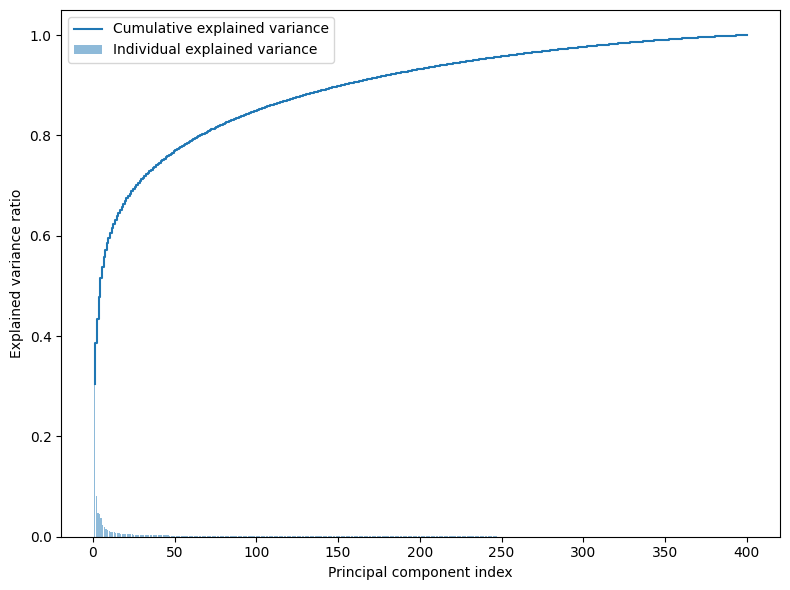

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'X_balanced' is your data matrix
# Here we're using a small random dataset as an example
# Replace this with: X_balanced = YOUR_DATA
# X_balanced = np.random.rand(100, 10)

pca = PCA()
pca.fit(X_balanced)

# Calculate the percentage of variance explained by each of the selected components
variance_explained = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


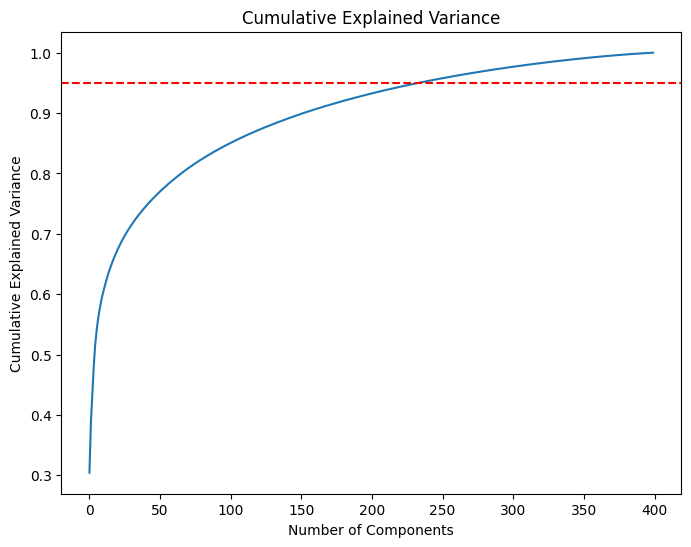

In [205]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_explained)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Find the number of components that explain 95% variance
n_components_95 = np.where(cumulative_variance_explained >= 0.95)[0][0] + 1


In [159]:
np.where(cumulative_variance_explained > .95)

(array([233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
        298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
        324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
        337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
        350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
        363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
        376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
        389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399]),)

## visualize the top 10 components (incorrect?)
plot the weights of the top 10 PCs projected back to brain

Wouldn't I have to do this differently for each class?

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig

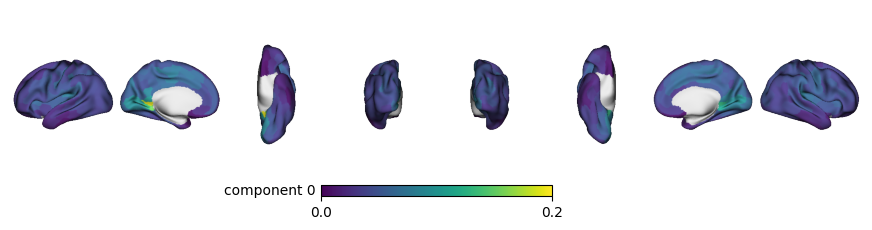

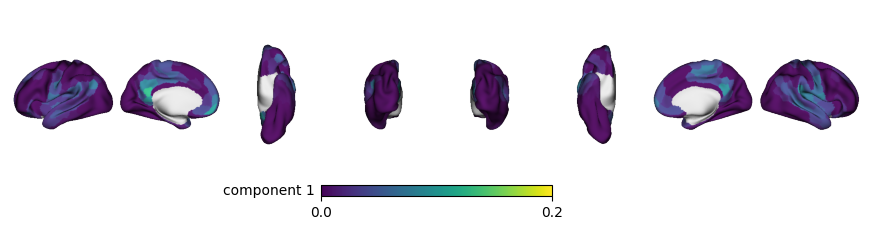

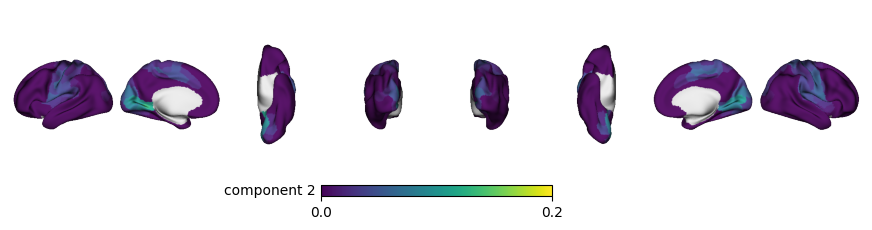

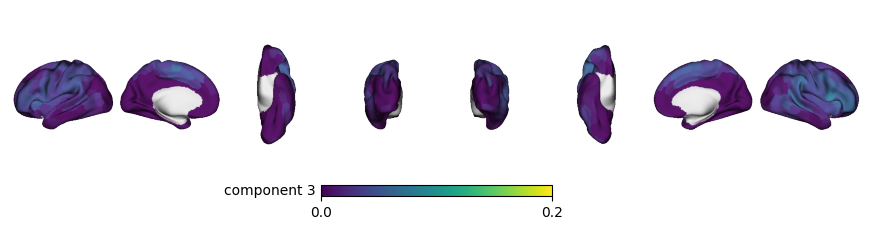

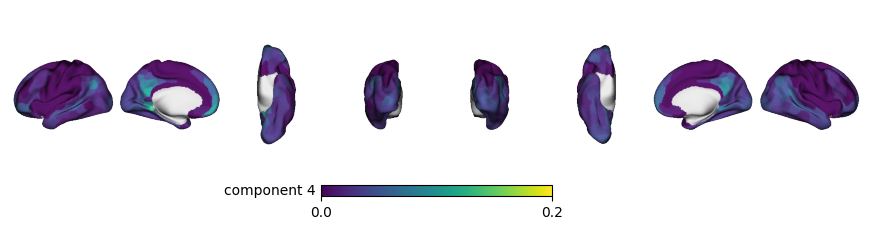

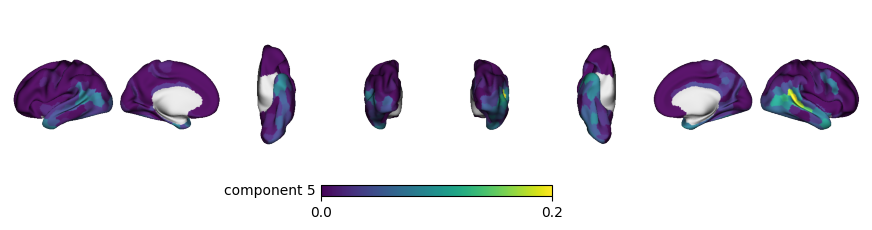

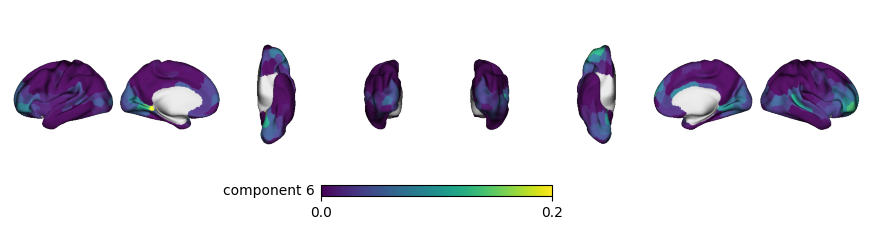

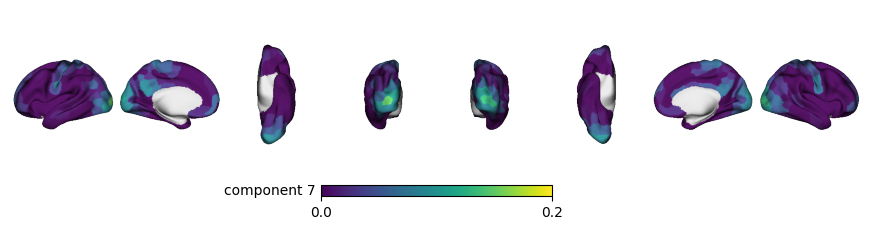

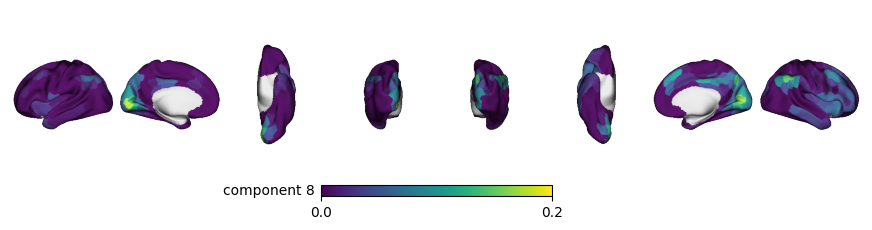

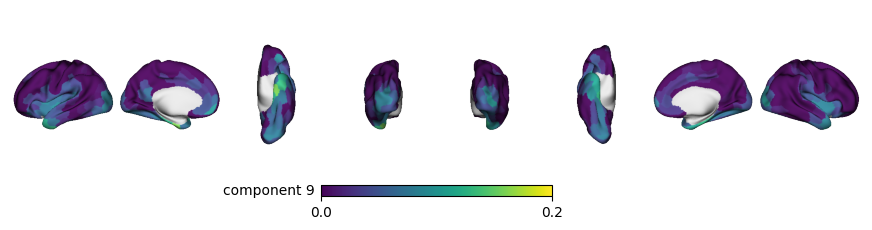

In [183]:
# Assuming you've already performed PCA as `pca = PCA(n_components=200).fit(X)`
# And you have a method to map the components back to brain space

for i in range(min(10, pca.n_components_)):  # Visualize the top 10 components
    component = pca.components_[i]
    # Convert the component to a brain map here if necessary
    
    comp = parc.inverse_transform(component)
    plot_brain_surfaces(image=comp, cbar_label=f'component {i}', cmap='viridis', color_range=(0,.1))



## SVM weights and PC

In [197]:
weights.size

400

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


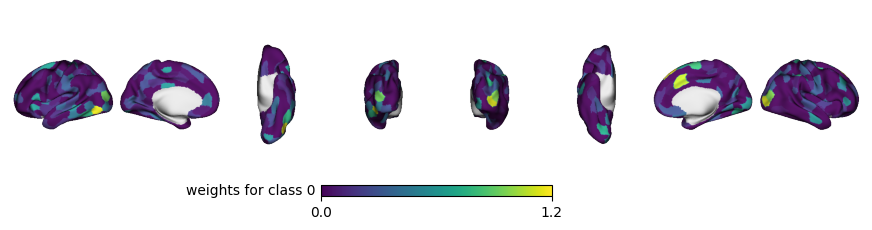

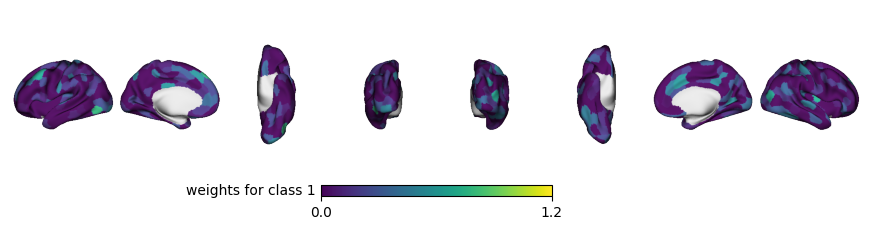

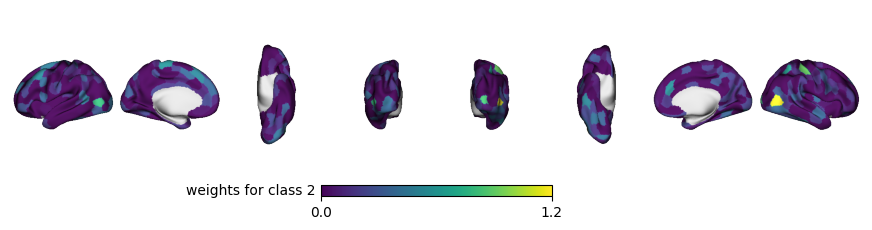

In [195]:
for i in range(len(svm.classes_)):  # There will be one set of weights per class
    weights = svm.coef_[i]

    comp = parc.inverse_transform(weights)
    plot_brain_surfaces(image=comp, cbar_label=f'weights for class {i}', cmap='viridis', color_range=(0,1.2))


## plot PCs per class

After using three PCs, project the SVM weigths back into the PCA components.
which components are imporant for classification

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1464/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


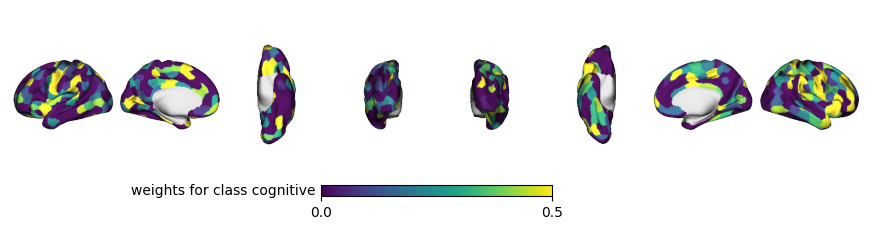

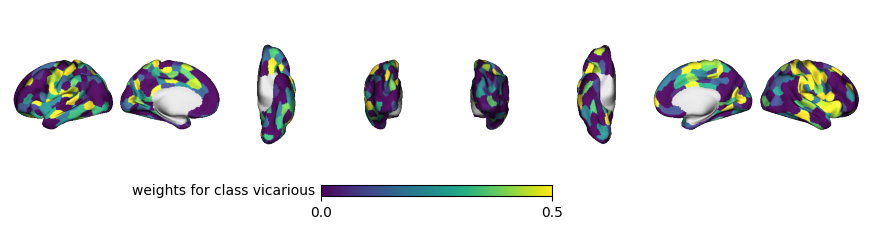

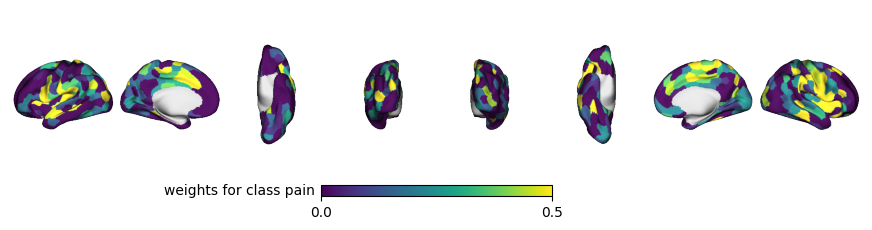

In [213]:
# # Get the SVM weights
# weights = svm.coef_

# # Project weights back to the original space
# weights_original_space = pca.inverse_transform(weights)

# # Plot the weights for each class
# for i in range(weights_original_space.shape[0]):
#     comp = parc.inverse_transform(weights_original_space[i])
#     plot_brain_surfaces(image=comp, cbar_label=f'weights for class {uniques[i]}', cmap='viridis', color_range=(0,.5))



## extract PC components per class (pain vicarios cognitive)
Then project the weights back to the extracted PCs

0
1


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


2


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15474/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


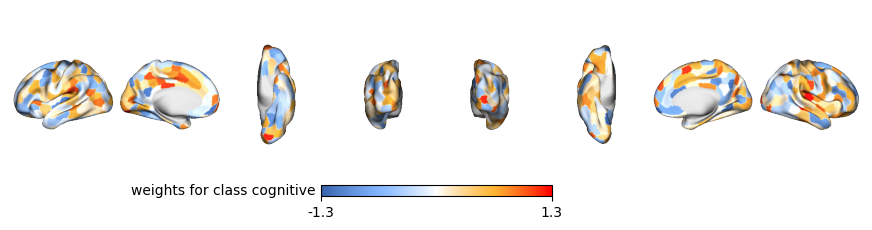

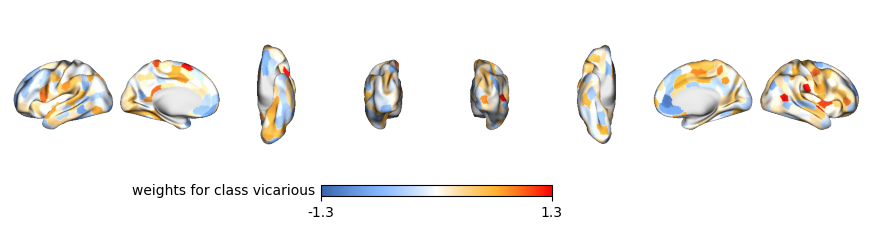

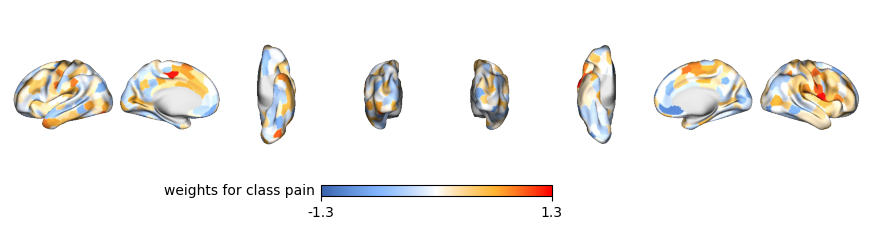

In [135]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Initialize a dictionary to hold the PCA models for each class
class_pca_models = {}
class_pca_components = {}

# Iterate over each class to create separate PCA models
for class_label in np.unique(Y_balanced):
    # Extract samples for the current class
    X_class = X_balanced[Y_balanced == class_label]
    
    # Create and fit PCA model for the current class
    pca = PCA()
    pca.fit(X_class)
    
    # Store the PCA model and the components
    class_pca_models[class_label] = pca
    class_pca_components[class_label] = pca.components_
for class_label in np.unique(Y_balanced):
    print(class_label)
    # Extract the weights for the current class from the SVM model
    svm_weights = svm.coef_[class_label]
    
    # Project the SVM weights back onto the original space using the PCA model for the current class
    original_space_weights = class_pca_models[class_label].inverse_transform(svm_weights)
    weights_original_space = pca.inverse_transform(original_space_weights)
    comp = parc.inverse_transform(weights_original_space)
    plot_brain_surfaces(image=comp, cbar_label=f'weights for class {uniques[class_label]}', cmap=cmap, color_range=(-1.3, 1.3))




In [218]:
# Assuming 'weights_original_space' is the weights projected back to the original space

# Find the max absolute weight value for setting the color range
max_abs_weight = np.max(np.abs(weights_original_space))

# Use this value to define the color range centered around zero
color_range = (-max_abs_weight, max_abs_weight)

# Now, you can use this color_range in your plotting function


In [219]:
color_range

(-1.3994931735236524, 1.3994931735236524)

In [221]:
weights.shape

(3, 400)